In [1]:
import pandas as pd
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Auto select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------------------------------------------------
# Load metadata
# ---------------------------------------------------
with open("/kaggle/input/cub2002011/CUB_200_2011/train_test_split.txt") as f:
    split = dict(line.strip().split() for line in f)

with open("/kaggle/input/cub2002011/CUB_200_2011/images.txt") as f:
    paths = dict(line.strip().split() for line in f)

with open("/kaggle/input/cub2002011/CUB_200_2011/image_class_labels.txt") as f:
    labels = dict(line.strip().split() for line in f)

# ---------------------------------------------------
# Select only FIRST 5 classes
# ---------------------------------------------------
selected_classes = set(list({int(v) for v in labels.values()})[:200])

print("Using classes:", selected_classes)

train_paths, train_labels = [], []
test_paths, test_labels = [], []

base = "/kaggle/input/cub2002011/CUB_200_2011/images/"

for img_id, rel in paths.items():
    cls = int(labels[img_id])
    if cls not in selected_classes:
        continue

    full = base + rel
    if split[img_id] == "1":
        train_paths.append(full)
        train_labels.append(cls)
    else:
        test_paths.append(full)
        test_labels.append(cls)

print("Train images:", len(train_paths))
print("Test images :", len(test_paths))

# ---------------------------------------------------
# Convert to DataFrames (path + class)
# ---------------------------------------------------
train_df = pd.DataFrame({"path": train_paths, "class": train_labels})
test_df  = pd.DataFrame({"path": test_paths , "class": test_labels})

# ---------------------------------------------------
# Per-class sample counts
# ---------------------------------------------------

train_count = train_df["class"].value_counts().sort_index()
test_count  = test_df["class"].value_counts().sort_index()

print("\n===== TRAIN PER-CLASS COUNTS =====")
print(train_count)

print("\n===== TEST PER-CLASS COUNTS =====")
print(test_count)

print("\n===== SUMMARY =====")
print("Train: classes =", train_count.index.nunique(),
      "| min =", train_count.min(),
      "| max =", train_count.max(),
      "| avg =", train_count.mean())

print("Test : classes =", test_count.index.nunique(),
      "| min =", test_count.min(),
      "| max =", test_count.max(),
      "| avg =", test_count.mean())

# ---------------------------------------------------
# Dataset class with transforms
# ---------------------------------------------------
transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

class CUBDataset(Dataset):
    def __init__(self, df, transform):
        self.paths = df["path"].values
        self.labels = df["class"].values
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transform(img)
        cls = self.labels[idx] - 1
        return img, cls

# ---------------------------------------------------
# Dataloaders
# ---------------------------------------------------
train_dataset = CUBDataset(train_df, transform_train)
test_dataset = CUBDataset(test_df, transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset , batch_size=32, shuffle=False, num_workers=2)

print("Train loader batches:", len(train_loader))
print("Test loader batches :", len(test_loader))

Using device: cuda
Using classes: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200}
Train images: 5994
Test images : 5794

===== TRAIN PER-CLASS COUNTS =====


============= METRIC LEARNING EVALUATION ==================
Recall@1 = 0.5735243355195029
Recall@2 = 0.6805315843976527
Recall@4 = 0.7713151536071798
Recall@8 = 0.8455298584742837

NMI = 0.7285864278548827
F1  = 0.007226039352869438

Pairwise Precision = 0.009907411357092184
Pairwise Recall    = 0.980819817163073



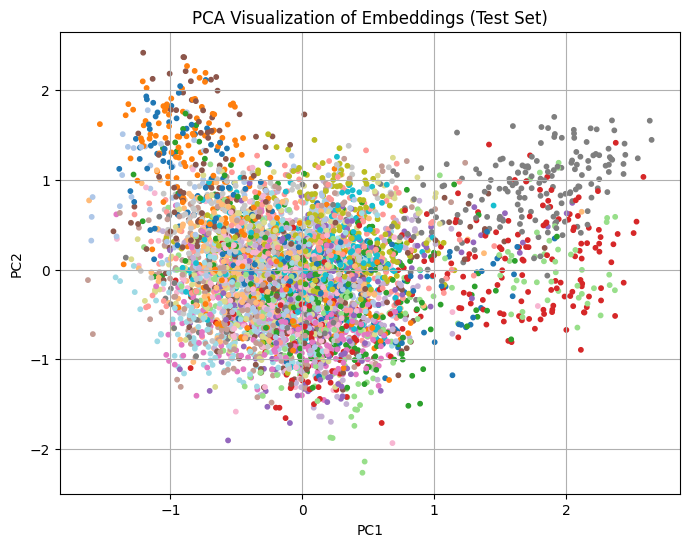

⚠️ loss_list not found. Make sure you collected epoch losses during training.


In [8]:
# ===============================================================
#   EVALUATION (AUTO-DETECT DVML OR NON-DVML)
# ===============================================================

import torch
import torch.nn.functional as F
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, f1_score
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt


# -------------------------------------------------------
# Extract embeddings (DVML + NON-DVML)
# -------------------------------------------------------
def extract_embeddings(model, loader):
    E, L = [], []
    model.eval()

    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(device)

            # Detect DVML or Not
            if "noise_scale" in model.forward.__code__.co_varnames:
                out = model(imgs, 0.0)
            else:
                out = model(imgs)

            # --- DVML (6 outputs) ---
            if isinstance(out, tuple) and len(out) == 6:
                z_i, z_v, mu, logvar, f, f_hat = out
                z = z_i

            # --- NON-DVML (single output) ---
            else:
                z = out

            E.append(z.cpu())
            L.append(lbls.cpu())

    return torch.cat(E), torch.cat(L)


# -------------------------------------------------------
# Recall@K
# -------------------------------------------------------
def recall_at_k(E, L, K=1):
    E = F.normalize(E, dim=1)
    sim = E @ E.t()

    N = len(L)

    # Remove self-match
    sim[range(N), range(N)] = -1

    _, idx = sim.topk(K, dim=1)
    return sum(L[i] in L[idx[i]] for i in range(N)) / N


# -------------------------------------------------------
# Clustering Metrics
# -------------------------------------------------------
def clustering_metrics(E, L, num_classes):
    km = KMeans(n_clusters=num_classes, n_init=10)
    clusters = km.fit_predict(E)

    nmi = normalized_mutual_info_score(L, clusters)
    f1  = f1_score(L, clusters, average="macro")

    return nmi, f1


# -------------------------------------------------------
# Pairwise precision/recall
# -------------------------------------------------------
def pairwise_precision_recall(E, L):
    D = pairwise_distances(E)
    y_true = (L[:, None] == L[None, :]).astype(int)

    thr = np.median(D)
    y_pred = (D < thr).astype(int)

    TP = (y_pred * y_true).sum()
    FP = (y_pred * (1 - y_true)).sum()
    FN = ((1 - y_pred) * y_true).sum()

    precision = TP / (TP + FP + 1e-9)
    recall    = TP / (TP + FN + 1e-9)
    return precision, recall


# ===============================================================
#  LOSS PLOT (AFTER TRAINING)
# ===============================================================

def plot_loss_curve(loss_list):
    plt.figure(figsize=(7,5))
    plt.plot(loss_list, marker='o')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()


# ===============================================================
#  VISUALIZE EMBEDDINGS USING PCA (2D)
# ===============================================================

def plot_pca_clusters(E, L, num_samples=5000):
    E = E.numpy()
    L = L.numpy()

    # Downsample for speed
    if len(E) > num_samples:
        idx = np.random.choice(len(E), num_samples, replace=False)
        E = E[idx]
        L = L[idx]

    pca = PCA(n_components=2)
    X = pca.fit_transform(E)

    plt.figure(figsize=(8,6))
    scatter = plt.scatter(X[:,0], X[:,1], c=L, cmap="tab20", s=10)
    plt.title("PCA Visualization of Embeddings (Test Set)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.show()


# ===============================================================
# RUN EVALUATION FOR BOTH DVML AND NON-DVML MODELS
# ===============================================================
E, L = extract_embeddings(model, test_loader)
num_classes = len(torch.unique(L))

print("\n============= METRIC LEARNING EVALUATION ==================")

# Recall@K
for k in [1, 2, 4, 8]:
    print(f"Recall@{k} =", recall_at_k(E, L, k))

# Clustering
nmi, f1 = clustering_metrics(E.numpy(), L.numpy(), num_classes)
print("\nNMI =", nmi)
print("F1  =", f1)

# Pairwise precision & recall
prec, rec = pairwise_precision_recall(E.numpy(), L.numpy())
print("\nPairwise Precision =", prec)
print("Pairwise Recall    =", rec)

print("===========================================================\n")

# -------------------------------------------------------
# PCA Visualization
# -------------------------------------------------------
plot_pca_clusters(E, L)

# -------------------------------------------------------
# Loss Plot (ASSUMES you collected loss_list)
# -------------------------------------------------------
try:
    plot_loss_curve(loss_list)
except:
    print("⚠️ loss_list not found. Make sure you collected epoch losses during training.")



==================== EVALUATION (DVML) ====================
Recall@1 = 0.5735243355195029
Recall@2 = 0.6805315843976527
Recall@4 = 0.7713151536071798
Recall@8 = 0.8455298584742837

NMI = 0.7236379714506083
F1  = 0.009077082245713785

Pairwise Precision = 0.009907411357092184
Pairwise Recall    = 0.980819817163073



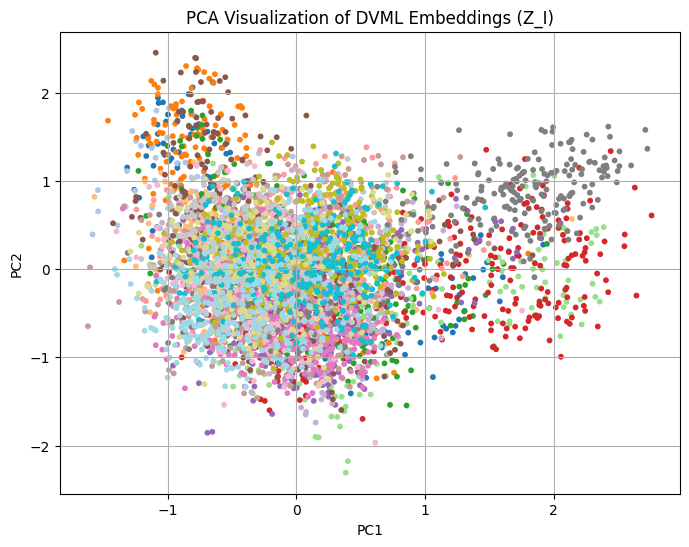

⚠️ loss_list not defined in training loop. Add: loss_list.append(loss.item())


In [9]:
# ===============================================================
#   EVALUATION + LOSS CURVES + PCA CLUSTER VISUALIZATION
# ===============================================================

import torch
import torch.nn.functional as F
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, f1_score
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt


# -------------------------------------------------------
# 1) Extract embeddings for DVML (z_i only)
# -------------------------------------------------------
def extract_embeddings(model, loader):
    E, L = [], []
    model.eval()

    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(device)

            # DVML has noise_scale argument
            z_i, z_v, mu, logvar, f, f_hat = model(imgs, noise_scale=0.0)

            E.append(z_i.cpu())
            L.append(lbls.cpu())

    return torch.cat(E), torch.cat(L)


# -------------------------------------------------------
# 2) Recall@K
# -------------------------------------------------------
def recall_at_k(E, L, K=1):
    E = F.normalize(E, dim=1)
    sim = E @ E.t()

    N = len(L)
    sim[range(N), range(N)] = -1  # self-match remove

    _, idx = sim.topk(K, dim=1)
    return sum(L[i] in L[idx[i]] for i in range(N)) / N


# -------------------------------------------------------
# 3) Clustering metrics
# -------------------------------------------------------
def clustering_metrics(E, L, num_classes):
    km = KMeans(n_clusters=num_classes, n_init=10)
    C = km.fit_predict(E)  # cluster indices

    nmi = normalized_mutual_info_score(L, C)
    f1  = f1_score(L, C, average="macro")

    return nmi, f1


# -------------------------------------------------------
# 4) Pairwise precision/recall
# -------------------------------------------------------
def pairwise_precision_recall(E, L):
    D = pairwise_distances(E)
    y_true = (L[:, None] == L[None, :]).astype(int)
    thr = np.median(D)
    y_pred = (D < thr).astype(int)

    TP = (y_pred * y_true).sum()
    FP = (y_pred * (1 - y_true)).sum()
    FN = ((1 - y_pred) * y_true).sum()

    precision = TP / (TP + FP + 1e-9)
    recall    = TP / (TP + FN + 1e-9)

    return precision, recall


# -------------------------------------------------------
# 5) Plot loss curve
# -------------------------------------------------------
def plot_loss_curve(loss_list):
    plt.figure(figsize=(7,5))
    plt.plot(loss_list, marker='o', linewidth=2)
    plt.title("Training Loss per Epoch (DVML)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()


# -------------------------------------------------------
# 6) PCA visualization
# -------------------------------------------------------
def plot_pca(E, L, num_points=6000):
    E = E.numpy()
    L = L.numpy()

    if len(E) > num_points:
        idx = np.random.choice(len(E), num_points, replace=False)
        E = E[idx]
        L = L[idx]

    pca = PCA(n_components=2)
    X = pca.fit_transform(E)

    plt.figure(figsize=(8,6))
    plt.scatter(X[:,0], X[:,1], c=L, cmap='tab20', s=10)
    plt.title("PCA Visualization of DVML Embeddings (Z_I)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.show()


# -------------------------------------------------------
# 7) t-SNE visualization (optional, slower)
# -------------------------------------------------------
def plot_tsne(E, L, num_points=4000):
    E = E.numpy()
    L = L.numpy()

    if len(E) > num_points:
        idx = np.random.choice(len(E), num_points, replace=False)
        E = E[idx]
        L = L[idx]

    tsne = TSNE(n_components=2, perplexity=30, learning_rate="auto", init="random")
    X = tsne.fit_transform(E)

    plt.figure(figsize=(8,6))
    plt.scatter(X[:,0], X[:,1], c=L, cmap='tab20', s=10)
    plt.title("t-SNE Visualization of DVML Embeddings")
    plt.xlabel("tSNE-1")
    plt.ylabel("tSNE-2")
    plt.grid(True)
    plt.show()


# ===============================================================
# RUN EVALUATION
# ===============================================================
E, L = extract_embeddings(model, test_loader)
num_classes = len(torch.unique(L))

print("\n==================== EVALUATION (DVML) ====================")

# Recall@K
for k in [1,2,4,8]:
    print(f"Recall@{k} =", recall_at_k(E, L, k))

# NMI + F1
nmi, f1 = clustering_metrics(E.numpy(), L.numpy(), num_classes)
print("\nNMI =", nmi)
print("F1  =", f1)

# Pairwise PR
prec, rec = pairwise_precision_recall(E.numpy(), L.numpy())
print("\nPairwise Precision =", prec)
print("Pairwise Recall    =", rec)

print("===========================================================\n")

# -------------------------------------------------------
# VISUALIZATION
# -------------------------------------------------------
plot_pca(E, L)     # PCA 2D
# plot_tsne(E, L)  # t-SNE (uncomment to run, slower)

# -------------------------------------------------------
# LOSS CURVE (requires you collect loss_list)
# -------------------------------------------------------
try:
    plot_loss_curve(loss_list)
except:
    print("⚠️ loss_list not defined in training loop. Add: loss_list.append(loss.item())")